# Goals

* Get the ground-truth organism for each SRA experiment

In [1]:
import os
from pathlib import Path
import pandas as pd
import plotnine as pn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from pypika import Query, Table, functions as fn

from SRAgent.db.connect import db_connect

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 4)
pn.theme_set(pn.theme_bw())

In [3]:
# get base directory
base_dir = !git rev-parse --show-toplevel
base_dir = Path(base_dir[0])

In [4]:
os.environ["DYNACONF"] = "prod"

# SRA BigQuery for organism info

In [5]:
# run the script to get the release dates
exe = base_dir.parent / "SRAgent" / "scripts" / "get-srx-organism.py"
organism_file = base_dir / "data" / "get-srx-organism" / "2025-07-16_SRX-organism.csv"
organism_file.parent.mkdir(parents=True, exist_ok=True)

In [6]:
# create a slurm bash script
job = f"""#!/bin/bash
#SBATCH --job-name=sra-bigquery-organisms
#SBATCH --output=sra-bigquery-organisms.out
#SBATCH --error=sra-bigquery-organisms.err
#SBATCH --time=48:00:00
#SBATCH --partition=cpu_batch
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=1
#SBATCH --cpus-per-task=2
#SBATCH --mem=8G

{exe} \\
    --tenant prod \\
    --use-db \\
    --all-accessions \\
    --just-star-results \\
    --output {organism_file}
"""
# save the job to a file
with open("sra-bigquery-organisms.sh", "w") as f:
    f.write(job)

# print the job
print(job)


#!/bin/bash
#SBATCH --job-name=sra-bigquery-organisms
#SBATCH --output=sra-bigquery-organisms.out
#SBATCH --error=sra-bigquery-organisms.err
#SBATCH --time=48:00:00
#SBATCH --partition=cpu_batch
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=1
#SBATCH --cpus-per-task=2
#SBATCH --mem=8G

/home/nickyoungblut/dev/python/SRAgent/scripts/get-srx-organism.py \
    --tenant prod \
    --use-db \
    --all-accessions \
    --just-star-results \
    --output /home/nickyoungblut/dev/python/scBaseCount_analysis/data/get-srx-organism/2025-07-16_SRX-organism.csv



In [7]:
# submit job
#!sbatch sra-bigquery-organisms.sh

## Compare bigquery with scBaseCount

In [8]:
# read in the organism file
df_org = pd.read_csv(organism_file)
df_org

,srx_accession,organism,sample_accession
0,SRX20966742,Acacia myrtifolia,SRS18239599
1,SRX20966741,Acacia myrtifolia,SRS18239597
...,...,...,...
211960,NRX0000533,NaN,NaN
211961,NRX0000351,NaN,NaN


In [9]:
# get distinct per srx_accession & organism
df_org = df_org.drop_duplicates(subset=["srx_accession", "organism"]).reset_index(drop=True)
# remove rows with no organism
df_org = df_org[~df_org["organism"].isna()]
# replacement map
replacement_map = {
    "Mus musculus domesticus": "Mus musculus",
    "Sus scrofa domesticus": "Sus scrofa",
    "Oryza sativa Japonica Group": "Oryza sativa",
    "Mustela putorius furo" : "Mustela putorius",
    "Canis lupus familiaris" : "Canis lupus",
    "Trachemys scripta elegans" : "Trachemys scripta",
    "Zea mays subsp. parviglumis" : "Zea mays",
    "Mus musculus musculus x Mus musculus castaneus" : "Mus musculus",
}
# replace with replacement map
df_org["organism"] = df_org["organism"].replace(replacement_map)
df_org

,srx_accession,organism,sample_accession
0,SRX20966742,Acacia myrtifolia,SRS18239599
1,SRX20966741,Acacia myrtifolia,SRS18239597
...,...,...,...
210671,SRX22858869,wastewater metagenome,SRS19834404
210672,SRX29397148,wastewater metagenome,SRS25567401


In [10]:
# summarize
pd.set_option('display.max_rows', 30)
df_org["organism"].value_counts().reset_index().sort_values(by="count", ascending=False).reset_index(drop=True).head(30)

,organism,count
0,Homo sapiens,89331
1,Mus musculus,83578
2,metagenome,7947
3,Gallus gallus,7105
4,Pan troglodytes,4325
5,Macaca mulatta,2532
6,Danio rerio,2041
7,Rattus norvegicus,1929
8,Arabidopsis thaliana,1587
9,Sus scrofa,1488


In [11]:
# check for duplidate accessions
pd.set_option('display.max_rows', 4)
df_org[df_org["srx_accession"].duplicated()]

,srx_accession,organism,sample_accession


## All SRAgent results

In [12]:
# get metadata with STAR results
meta_table = Table('srx_metadata')
query = (
    Query.from_(meta_table)
    .select(
        meta_table.srx_accession,
        meta_table.tech_10x,
        meta_table.organism,
        meta_table.czi_collection_id,
    )
    .where(
        meta_table.lib_prep == "10x_Genomics"
    )
)

with db_connect() as conn:
    df_meta = pd.read_sql_query(str(query), conn)
df_meta

,srx_accession,tech_10x,organism,czi_collection_id
0,SRX22482811,5_prime_gex,Homo sapiens,None
1,SRX13824065,3_prime_gex,Mus musculus,None
...,...,...,...,...
105982,NRX0000735,3_prime_gex,Homo sapiens,None
105983,NRX0000736,3_prime_gex,Homo sapiens,None


In [13]:
# merge on srx_accession
df_meta = df_meta.merge(df_org, on="srx_accession", how="inner", suffixes=("_scBaseCount", "_BigQuery"))
df_meta

,srx_accession,tech_10x,organism_scBaseCount,czi_collection_id,organism_BigQuery,sample_accession
0,SRX22482811,5_prime_gex,Homo sapiens,None,Homo sapiens,SRS19496189
1,SRX13824065,3_prime_gex,Mus musculus,None,Mus musculus,SRS11703574
...,...,...,...,...,...,...
105054,SRX6060845,3_prime_gex,Mus musculus,None,Mus musculus,SRS4962123
105055,SRX5897016,3_prime_gex,Homo sapiens,None,Homo sapiens,SRS4818555


In [14]:
# accuracy of organism_scBaseCount
num_error = (df_meta["organism_scBaseCount"] != df_meta["organism_BigQuery"]).sum()
acc = (1 - num_error / len(df_meta)) * 100
print(f"Accuracy of organism_scBaseCount: {acc:.1f}%")

Accuracy of organism_scBaseCount: 99.8%


In [15]:
pd.set_option('display.max_rows', 200)
df_meta_mis = df_meta[df_meta["organism_scBaseCount"] != df_meta["organism_BigQuery"]]
df_meta_mis = df_meta_mis[df_meta_mis["organism_scBaseCount"] != "other"]

In [16]:
pd.set_option('display.max_rows', 4)

## STAR results

In [17]:
# get metadata with STAR results
meta_table = Table('srx_metadata')
star_table = Table('screcounter_star_results')
query = (
    Query.from_(meta_table)
    .inner_join(star_table)
    .on(meta_table.srx_accession == star_table.sample)
    .select(
        meta_table.srx_accession,
        meta_table.tech_10x,
        meta_table.organism,
        meta_table.czi_collection_id,
        star_table.estimated_number_of_cells
    )
    .where(
        star_table.feature == "GeneFull_Ex50pAS"
    )
    .where(
        meta_table.lib_prep == "10x_Genomics"
    )
)

with db_connect() as conn:
    df_meta = pd.read_sql_query(str(query), conn)
df_meta

,srx_accession,tech_10x,organism,czi_collection_id,estimated_number_of_cells
0,SRX22482811,5_prime_gex,Homo sapiens,None,4155
1,SRX13824065,3_prime_gex,Mus musculus,None,6348
...,...,...,...,...,...
61379,NRX0000646,3_prime_gex,Homo sapiens,None,7646
61380,NRX0000647,3_prime_gex,Homo sapiens,None,9573


In [18]:
# merge on srx_accession
df_meta = df_meta.merge(df_org, on="srx_accession", how="inner", suffixes=("_scBaseCount", "_BigQuery"))
df_meta = df_meta[~df_meta["organism_BigQuery"].isin(["Canis lupus", "Pan paniscus"])]
df_meta

,srx_accession,tech_10x,organism_scBaseCount,czi_collection_id,estimated_number_of_cells,organism_BigQuery,sample_accession
0,SRX22482811,5_prime_gex,Homo sapiens,None,4155,Homo sapiens,SRS19496189
1,SRX13824065,3_prime_gex,Mus musculus,None,6348,Mus musculus,SRS11703574
...,...,...,...,...,...,...,...
60589,SRX10955666,5_prime_gex,Mus musculus,None,13597,Mus musculus,SRS9033942
60590,ERX11467033,3_prime_gex,Homo sapiens,None,13539,Homo sapiens,ERS16449457


In [19]:
# summarize by organism
org_count = df_meta.groupby("organism_scBaseCount").size().reset_index(name="count")
org_count = org_count[org_count["count"] > 10]
org_count.sort_values("count", ascending=False)
#df_meta = df_meta[df_meta["organism_scBaseCount"].isin(org_count["organism_scBaseCount"])]

,organism_scBaseCount,count
12,Homo sapiens,34774
16,Mus musculus,21406
...,...,...
4,Chlorocebus aethiops,20
7,Equus caballus,13


In [20]:
# accuracy of organism_scBaseCount
num_error = (df_meta["organism_scBaseCount"] != df_meta["organism_BigQuery"]).sum()
acc = (1 - num_error / len(df_meta)) * 100
print(f"Accuracy of organism_scBaseCount: {acc:.1f}%")

Accuracy of organism_scBaseCount: 99.9%


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra-bigquery_organisms_cf-mtx.svg


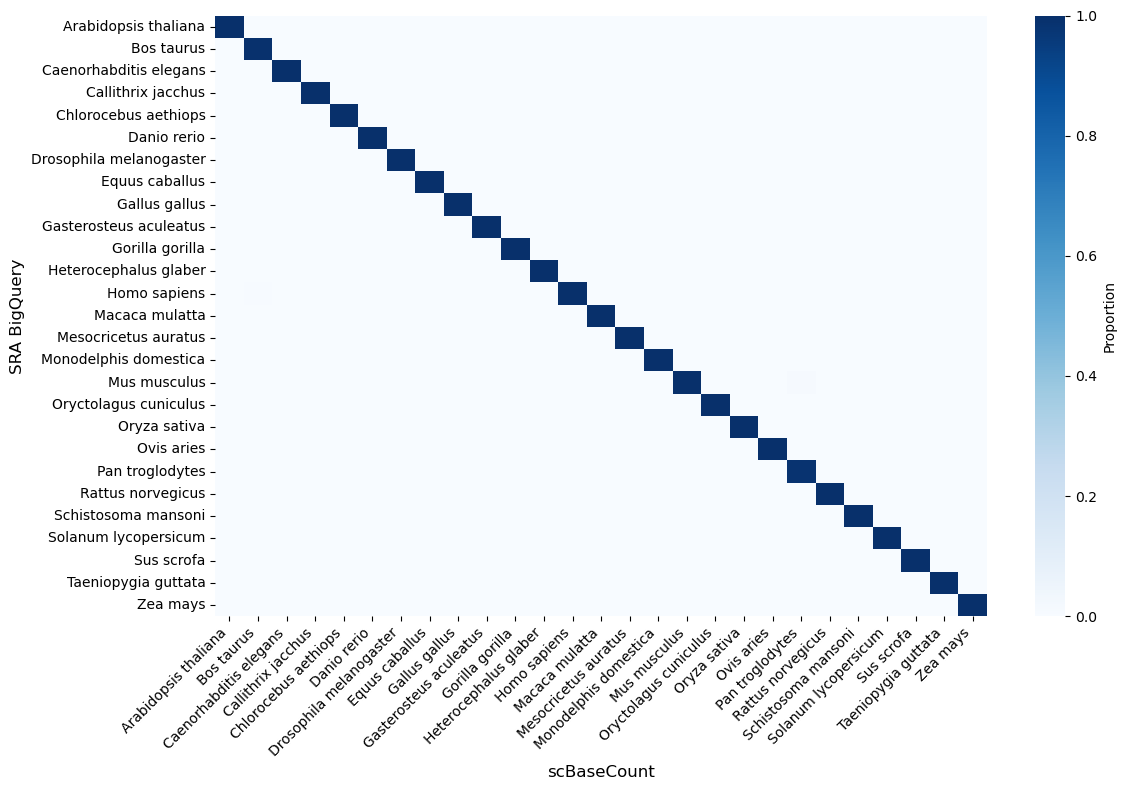

In [22]:
# create heatmap
from typing import Tuple, Optional
import numpy as np
def create_confusion_matrix(
    df: pd.DataFrame,
    predicted_col: str = "organism_scBaseCount",
    actual_col: str = "organism_BigQuery",
    normalize: bool = True,
    figsize: Tuple[int, int] = (8, 6),
    save_path: Optional[str] = None
) -> None:
    """Create and display a confusion matrix for organism classification.
    
    Args:
        df: DataFrame containing the classification results
        predicted_col: Column name for predicted organism labels
        actual_col: Column name for actual/ground truth organism labels
        normalize: If True, normalize per predicted organism (column-wise). If False, show raw counts
        figsize: Figure size as (width, height)
        save_path: Optional path to save the plot
    """
    
    # Get unique labels from both columns
    all_labels = sorted(list(set(df[predicted_col].unique()) | set(df[actual_col].unique())))
    
    # Create confusion matrix
    cm = confusion_matrix(df[actual_col], df[predicted_col], labels=all_labels)
    
    if normalize:
        # Normalize per predicted organism (column-wise normalization)
        cm_plot = cm.astype('float') / cm.sum(axis=0)  # Changed from axis=1 to axis=0
        # Handle division by zero (in case a predicted organism has no samples)
        cm_plot = np.nan_to_num(cm_plot, nan=0.0)
        cbar_label = 'Proportion'
        title_suffix = ' (Normalized per Predicted Organism)'
        vmin, vmax = 0, 1
        center = 0.5  # Set center point for diverging colormap
    else:
        cm_plot = cm
        cbar_label = 'Count'
        title_suffix = ' (Raw Counts)'
        vmin, vmax = None, None
        center = None  # No center for raw counts
    
    # Create the plot
    plt.figure(figsize=figsize)
    
    # Create heatmap with diverging colormap
    sns.heatmap(
        cm_plot,
        annot=False,  # Changed to False to show only colors
        cmap='Blues',  # Red-Blue reversed: blue(0) -> white(0.5) -> red(1)
        xticklabels=all_labels,
        yticklabels=all_labels,
        cbar_kws={'label': cbar_label},
        vmin=vmin,
        vmax=vmax,
        center=center  # Center the colormap at 0.5 for normalized data
    )
    plt.xlabel('scBaseCount', fontsize=12)
    plt.ylabel('SRA BigQuery', fontsize=12)
    
    # Rotate labels if they're long
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"File written to {save_path}")
    
    plt.show()

fig_file = base_dir / "figures" / "sra-bigquery_organisms_cf-mtx.svg"
create_confusion_matrix(df_meta, figsize=(12, 8), save_path=fig_file)

# session info

In [5]:
!conda list

# packages in environment at /home/nickyoungblut/miniforge3/envs/SRAgent_nb:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
_python_abi3_support      1.0                  hd8ed1ab_2    conda-forge
aiobotocore               2.23.0             pyhd8ed1ab_0    conda-forge
aiohappyeyeballs          2.6.1              pyhd8ed1ab_0    conda-forge
aiohttp                   3.11.14                  pypi_0    pypi
aioitertools              0.12.0             pyhd8ed1ab_1    conda-forge
aiosignal                 1.3.2              pyhd8ed1ab_0    conda-forge
anndata                   0.11.4             pyhd8ed1ab_0    conda-forge
annotated-types           0.7.0                    pypi_0    pypi
anthropic                 0.57.1                   pypi_0    pypi
anyio                     4.9.0                    pypi_0    pypi
appdir